# Model Understanding with Captum

This notebook is referenced from the seventh video in the [PyTorch Beginner Series](https://www.youtube.com/playlist?list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN) by Brad Heintz on YouTube. The video focuses on the basic concepts in PyTorch that are used to handle several deep learning tasks and demonstrates how these concepts come together to make PyTorch a robust machine learning framework. You can find the notebook associated with the video [here](https://pytorch.org/tutorials/beginner/introyt/captumyt.html).

This notebook focuses on understanding the machine learning model with the help of [Captum](https://captum.ai/). Captum is an open-source, extensible library for model interpretability built on PyTorch. The model interpretability is expressed in terms of _attributions_ in Captum. The three kinds of attributions available in Captum are as follows:

- Feature Attribution - explains an output based on the features of the input that generated it.
- Layer Attribution - examines the activity of a model's hidden layer after passing an input.
- Neuron Attribution - examines the activity of a single neuron after passing an input to it.


In [1]:
# Import libraries here
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from captum.attr import (
    IntegratedGradients,
    LayerAttribution,
    LayerGradCam,
    Occlusion,
)
from captum.attr import visualization as viz
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from torch import Tensor

# Set plot styles
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['figure.titlesize'] = 14

The various algorithms that are associated with these attributions can be categorised as:

|    -     | Gradient-based algorithms                                                                                          | Perturbation-based algorithms                                                                                                                             |
| :------: | ------------------------------------------------------------------------------------------------------------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------- |
|  Usage   | Calculates the backward gradients of a model output, layer output, or neuron activation with respect to the input. | Examines the changes in the ouputs of a model, layer, or neuron in response to changes in the input. These input perturbations can be directed or random. |
| Examples | Integrated Gradients, Layer Gradient Activation, and Neuron Conductance are gradient-based algorithms.             | Occlusion, Feature Ablation, and Feature Permutation are perturbation-based algorithms.                                                                   |

Captum also provides various helpful functions for visualizing attributions related to images. Captum Insights provides an easy-to-use API to create various visualizations for image, text, and arbitrary model types.


## An Example on Feature Attribution

This example involves using the pre-trained ResNet model to test various feature attribution algorithms on inputs and examine how the input images affect the output. It also involves the creation of various visualizations of the input attribution map for some test images.


In [2]:
# Get the ResNet model and activate evaluation mode
resnet_model = models.resnet18(weights='IMAGENET1K_V1')
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

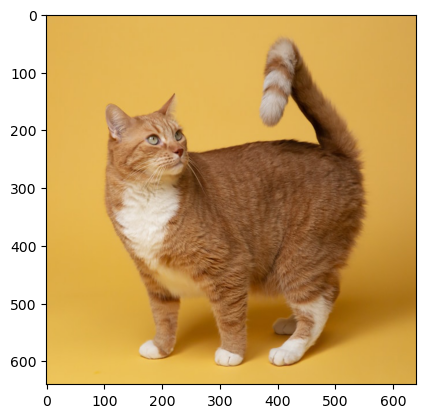

In [3]:
# Open a test image
cat_image = Image.open('../images/kabo-p6yH8VmGqxo-unsplash.jpg')

# Convert it to an array (640x640)
cat_image_data = np.asarray(cat_image)

# Plot the image data
plt.imshow(cat_image_data)
plt.show()

In [4]:
# Setup data transformers:
# - Size (model expects 224x224 3-color image)
# - Normalize (model expects a standard ImageNet normalization)
# - Unsqueeze (model expects a dummy batch dimension)

# Setup the sizing transformer
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

# Setup the normalization
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

# Transform the data
cat_image_transformed = transform(cat_image)
input_image = normalize(cat_image_transformed)
input_image = input_image.unsqueeze(0)

# Get the shape of the image
print(f'Input Tensor:\n{input_image}')
print(f'\nInput Shape:\n{input_image.size()}')

Input Tensor:
tensor([[[[ 1.7352,  1.7352,  1.7352,  ...,  1.5468,  1.5468,  1.5468],
          [ 1.7352,  1.7352,  1.7352,  ...,  1.5468,  1.5468,  1.5468],
          [ 1.7180,  1.7352,  1.7352,  ...,  1.5468,  1.5468,  1.5468],
          ...,
          [ 1.9407,  1.9407,  1.9407,  ...,  1.5982,  1.5982,  1.5982],
          [ 1.9407,  1.9407,  1.9407,  ...,  1.5982,  1.5982,  1.5982],
          [ 1.9407,  1.9407,  1.9407,  ...,  1.5982,  1.5982,  1.5982]],

         [[ 1.0455,  1.0455,  1.0455,  ...,  0.8704,  0.8704,  0.8704],
          [ 1.0455,  1.0455,  1.0455,  ...,  0.8704,  0.8704,  0.8704],
          [ 1.0455,  1.0455,  1.0455,  ...,  0.8704,  0.8704,  0.8704],
          ...,
          [ 1.3957,  1.3957,  1.3957,  ...,  0.9580,  0.9580,  0.9580],
          [ 1.3957,  1.3957,  1.3957,  ...,  0.9755,  0.9755,  0.9755],
          [ 1.3957,  1.3957,  1.3957,  ...,  0.9930,  0.9930,  0.9930]],

         [[-0.3927, -0.3753, -0.3578,  ..., -0.3927, -0.3927, -0.3927],
          [-0.39

In [5]:
# Load the labels
labels_path = '../data/imagenet_class_index.json'
with open(labels_path) as labels_file:
    imagenet_labels = json.load(labels_file)

imagenet_labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [6]:
# Produce output for the test image
output = F.softmax(resnet_model(input_image), dim=1)
print(f'Output Tensor:\n{output}\n')

# Get the prediction score and label index
prediction_score, prediction_label_idx = torch.topk(output, 1)

prediction_score.squeeze_()
prediction_label_idx.squeeze_()

prediction_label = imagenet_labels[str(prediction_label_idx.item())][1]
print('Predicted: {} ({:.5f}%)'.format(
    prediction_label,
    prediction_score.item() * 100,
))

Output Tensor:
tensor([[1.6292e-08, 1.2724e-08, 1.1506e-08, 5.1346e-08, 9.1151e-08, 1.2023e-07,
         1.3650e-07, 5.0149e-09, 1.6459e-08, 2.1313e-07, 3.9496e-09, 1.5683e-09,
         1.7121e-08, 2.2730e-08, 1.3598e-09, 1.3006e-07, 3.8591e-08, 8.0155e-08,
         4.3500e-09, 1.1708e-09, 6.8206e-07, 4.8917e-07, 8.9449e-07, 5.8844e-08,
         1.2736e-07, 1.0500e-07, 1.7482e-07, 1.0693e-07, 5.2830e-08, 1.8805e-08,
         1.1052e-06, 1.4724e-06, 2.7372e-07, 2.6469e-09, 3.3719e-09, 1.6638e-08,
         3.2956e-08, 2.6606e-08, 3.8822e-06, 3.3032e-08, 8.5445e-08, 2.1942e-08,
         4.9429e-09, 3.4511e-07, 5.0346e-08, 3.0198e-08, 4.5011e-08, 3.6791e-07,
         6.5180e-08, 4.8705e-08, 3.3346e-08, 2.3112e-06, 3.1848e-08, 3.4274e-08,
         6.7190e-08, 3.7808e-08, 1.4879e-08, 8.6449e-10, 4.0024e-08, 1.7614e-07,
         3.5392e-07, 8.8692e-08, 2.8266e-08, 2.1114e-08, 1.3847e-07, 2.1599e-08,
         2.7785e-06, 2.2198e-07, 8.3273e-08, 1.8129e-07, 1.3868e-08, 1.3248e-07,
         5.91

## Feature Attribution with Integrated Gradients

Integrated Gradients is a feature attribution algorithm that assigns importance scores to each input feature. It does this by approximating the integral of the model's output gradients with respect to the input features.

$$
\text{IntegratedGrads}_i^\text{approx}(x) \Coloneqq
    (x_i-x_i')\times\sum_{k=1}^m
    \frac{\partial F(\text{interpolated images})}{\partial x_i}
    \frac{1}{m}
$$

Where:

- $F$ is the model's prediction function.
- $i$ is the feature (individual pixel).
- $x$ is the input image tensor.
- $x'$ is the baseline image tensor.
- $k$ is the scaled feature perturbation constant.
- $m$ is the number of steps in the Riemann sum approximation of the integral.

This is referenced from: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients#unpack_formulas_into_code


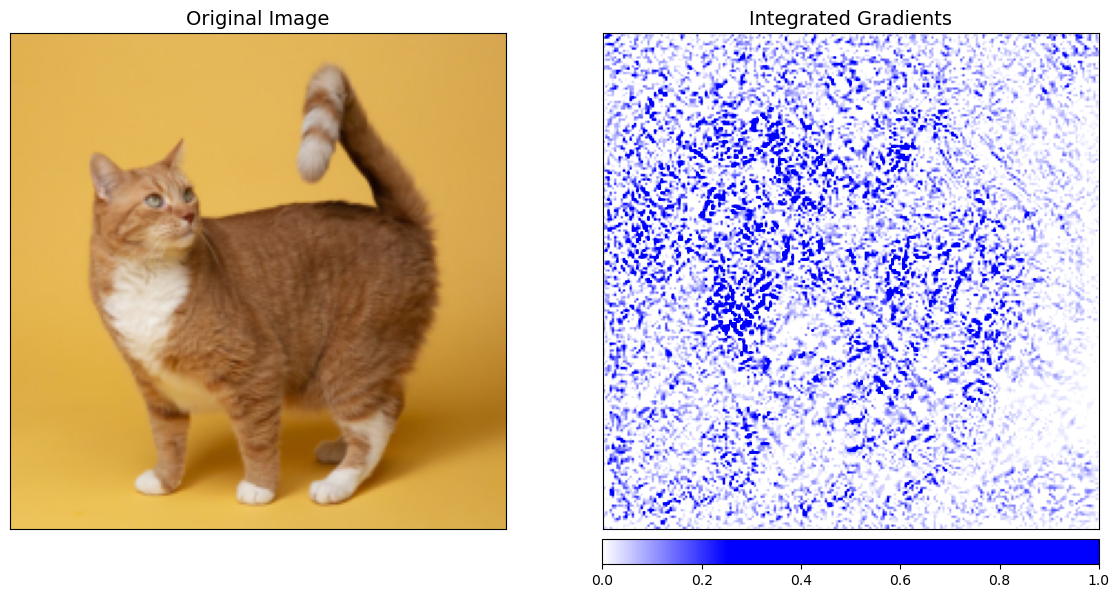

<Figure size 640x480 with 0 Axes>

In [7]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(resnet_model)

# Attribute the output target using the initialized algorithm
attributions_integrated_grads = integrated_gradients.attribute(
    inputs=input_image,
    target=prediction_label_idx,
    n_steps=200,
)

# Create a default cmap
default_cmap = LinearSegmentedColormap.from_list(
    name='custom_blue',
    colors=[(0.00, '#ffffff'), (0.25, '#0000ff'), (1.00, '#0000ff')],
    N=256,
)

# Prepare the original image
original_image = np.transpose(
    cat_image_transformed.squeeze().cpu().detach().numpy(),
    axes=(1, 2, 0),
)

# Prepare the attributions image
attributions_image = np.transpose(
    attributions_integrated_grads.squeeze().cpu().detach().numpy(),
    axes=(1, 2, 0),
)

# Show the image with the integrated gradients
viz.visualize_image_attr_multiple(
    attr=attributions_image,
    original_image=original_image,
    methods=['original_image', 'heat_map'],
    cmap=default_cmap,
    show_colorbar=True,
    signs=['all', 'positive'],
    titles=['Original Image', 'Integrated Gradients'],
    fig_size=(12, 6),
)

plt.tight_layout()
plt.show();

## Feature Attribution with Occlusion

Occlusion is a perturbation-based attribution algorithm that involves replacing sections of the input image, and examining its effect on the output signal. This masking gives a very instructive view of what regions of the image are identified as "object-like" by the model.


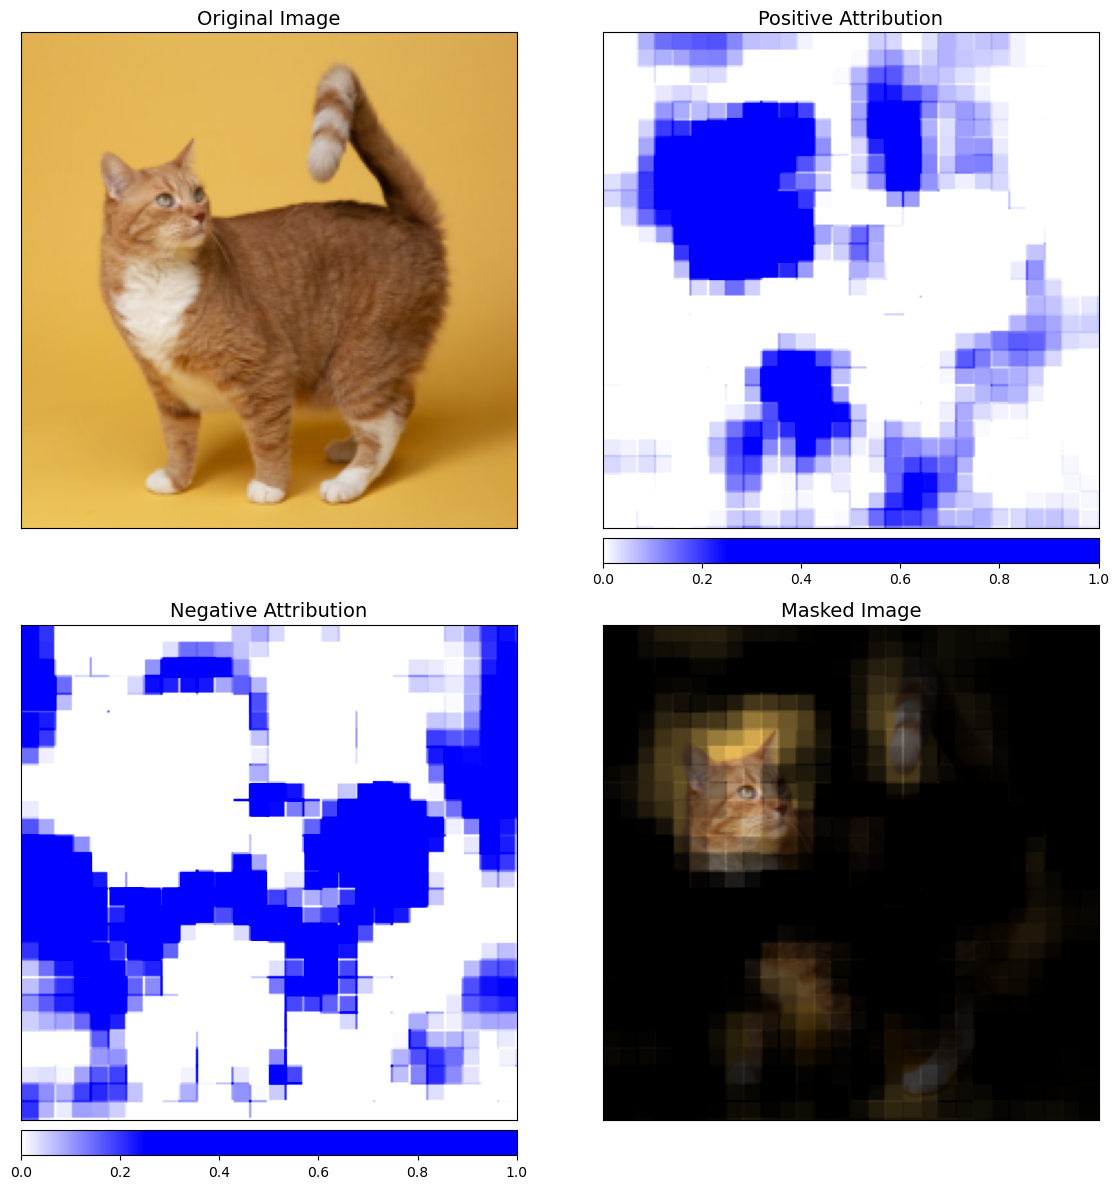

In [8]:
# Initialize the occlusion algorithm
occlusion = Occlusion(resnet_model)

# Create the attributions using the algorithm
attributions_occlusion = occlusion.attribute(inputs=input_image,
                                             target=prediction_label_idx,
                                             strides=(3, 8, 8),
                                             sliding_window_shapes=(3, 15, 15),
                                             baselines=0)

# Create a custom colormap
default_cmap = LinearSegmentedColormap.from_list(
    name='custom_blue',
    colors=[(0.00, '#ffffff'), (0.25, '#0000ff'), (1.00, '#0000ff')],
    N=256,
)

# Prepare the original image
original_image = np.transpose(
    cat_image_transformed.squeeze().cpu().detach().numpy(),
    axes=(1, 2, 0),
)


# Prepare the attributions image
attributions_image = np.transpose(
    attributions_occlusion.squeeze().cpu().detach().numpy(),
    axes=(1, 2, 0),
)

# Create subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Define the titles and the visualization methods
titles = ['Original Image', 'Positive Attribution',
          'Negative Attribution', 'Masked Image']
methods = ['original_image', 'heat_map', 'heat_map', 'masked_image']
signs = ['all', 'positive', 'negative', 'positive']

# Plot each visualization in the respective subplot
for i, (title, method, sign) in enumerate(zip(titles, methods, signs)):
    # Get the row and column index
    row, col = divmod(i, 2)

    # Plot the visualization
    viz.visualize_image_attr(
        attr=attributions_image,
        original_image=original_image,
        method=method,
        cmap=default_cmap,
        show_colorbar=True,
        sign=sign,
        title=title,
        plt_fig_axis=(fig, axes[row, col]),
        use_pyplot=False,
    )

plt.tight_layout()
plt.show();

## Layer Attribution with Layer GradCAM

GradCAM (Gradient-weighted Class Activation Mapping) works in the following way:

- Computes gradients of the target output with respect to the given layer.
- Averages the results for each output channel.
- Multiplies the average gradient for each channel by the layer activations.
- These results are then summed over all channels.

It is used for convolutional neural networks since the activity of convolutional layers is often mapped spatially onto the input. GradCAM attributions are often upsampled and used to mask the input. The paper that proposed this technique can be found [here](https://arxiv.org/abs/1610.02391).


In [9]:
def examine_layer(model: nn.Module, layer: nn.Module, title: str) -> None:
    # Initialize the Layer GradCAM
    layer_gradcam = LayerGradCam(model, layer)

    # Create the attributions with the Layer GradCAM
    attributions_layer_gradcam = layer_gradcam.attribute(
        inputs=input_image,
        target=prediction_label_idx,
    )

    # Plot the output of the layer using the attributions
    viz.visualize_image_attr(
        attr=attributions_layer_gradcam[0].cpu().permute(1, 2, 0).detach().numpy(),
        sign='all',
        title=title,
    )
    plt.show()

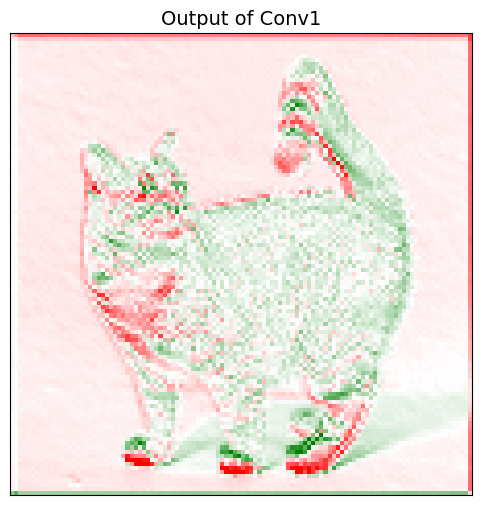

In [10]:
# Plot for the first conv layer
examine_layer(
    model=resnet_model,
    layer=resnet_model.conv1,
    title='Output of Conv1',
)

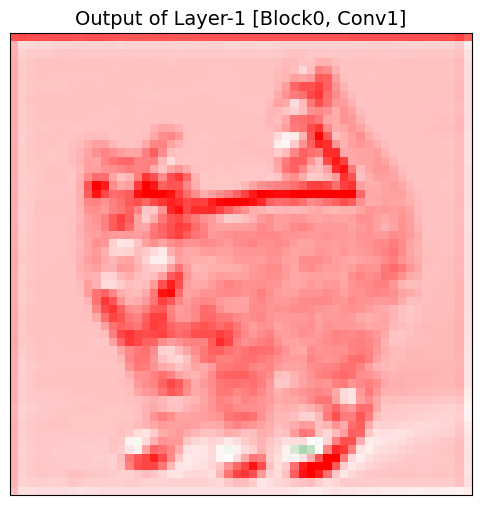

In [11]:
# Plot for layer-1: block0, conv1
examine_layer(
    model=resnet_model,
    layer=resnet_model.layer1[0].conv1,
    title='Output of Layer-1 [Block0, Conv1]',
)

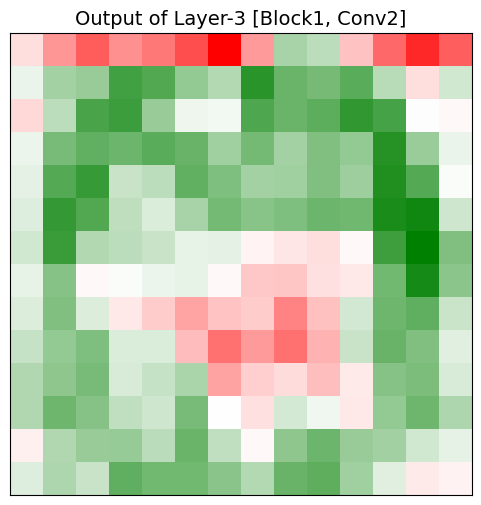

In [12]:
# Plot for layer-3: block1, conv2
examine_layer(
    model=resnet_model,
    layer=resnet_model.layer3[1].conv2, 
    title='Output of Layer-3 [Block1, Conv2]',
)

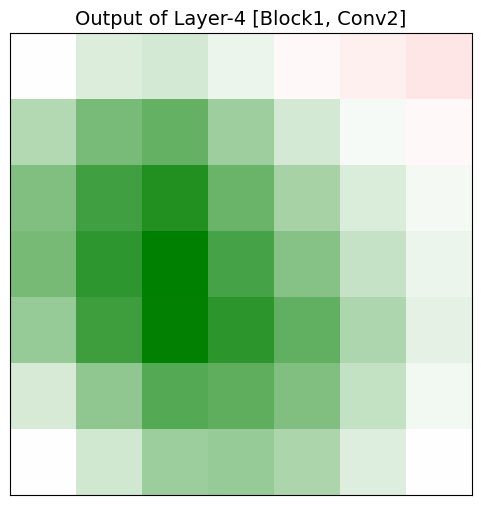

In [13]:
# Plot for the final convolutional layer
examine_layer(
    model=resnet_model,
    layer=resnet_model.layer4[1].conv2,
    title='Output of Layer-4 [Block1, Conv2]',
)

Shape of Input Image            : torch.Size([1, 3, 224, 224])
Shape of Attributions           : torch.Size([1, 1, 14, 14])
Shape of Upsampled Attributions : torch.Size([1, 1, 224, 224])


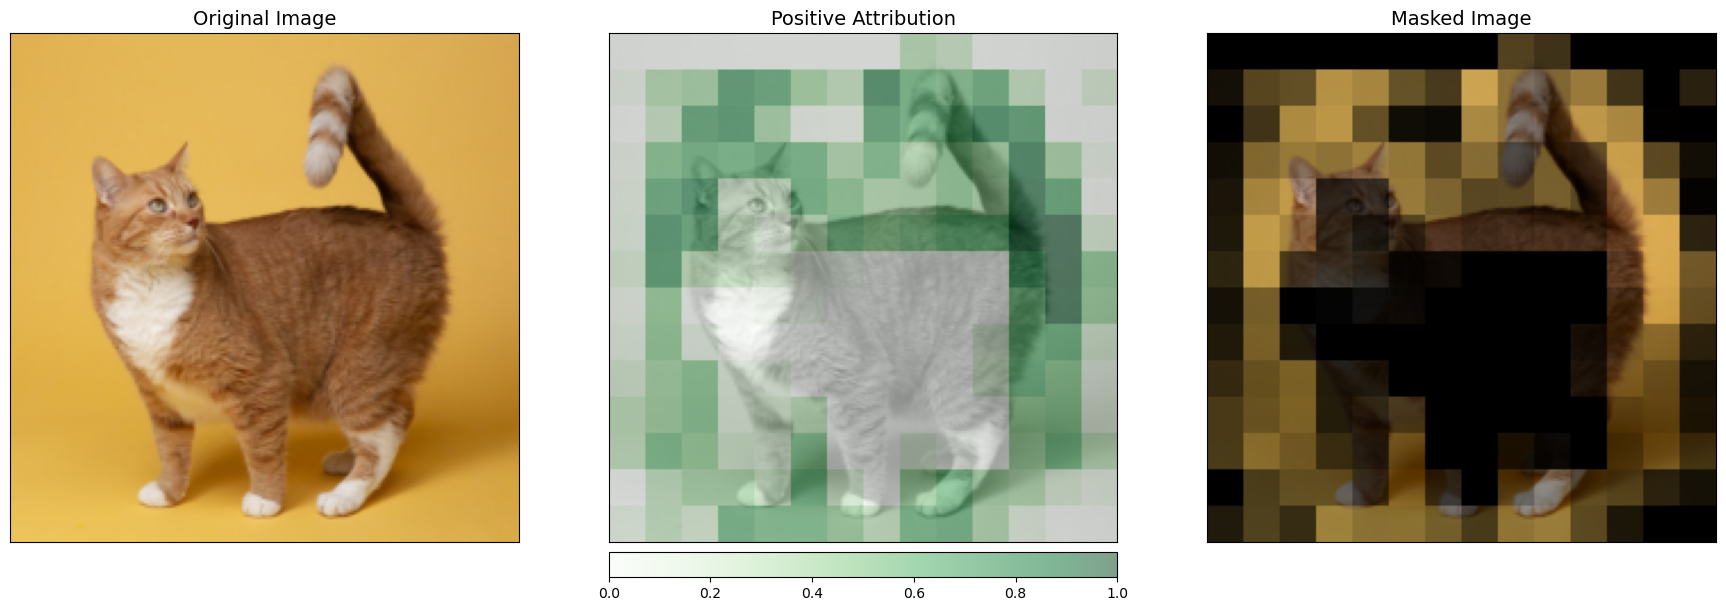

In [14]:
# Initialize the Layer GradCAM
layer_gradcam = LayerGradCam(resnet_model, resnet_model.layer3[1].conv2)

# Create attributions with the Layer GradCAM
attributions_layer_gradcam = layer_gradcam.attribute(
    inputs=input_image,
    target=prediction_label_idx,
)

# Upsample the attributions
upsample_attr_layer_gradcam = LayerAttribution.interpolate(
    layer_attribution=attributions_layer_gradcam,
    interpolate_dims=input_image.shape[2:],
)

print(f'Shape of Input Image            : {input_image.shape}')
print(f'Shape of Attributions           : {attributions_layer_gradcam.shape}')
print(f'Shape of Upsampled Attributions : {upsample_attr_layer_gradcam.shape}')

# Plot the image with upsampled attributions
viz.visualize_image_attr_multiple(
    attr=upsample_attr_layer_gradcam[0].cpu().permute(1, 2, 0).detach().numpy(),
    original_image=cat_image_transformed.permute(1, 2, 0).numpy(),
    methods=['original_image', 'blended_heat_map', 'masked_image'],
    signs=['all', 'positive', 'positive'],
    titles=['Original Image', 'Positive Attribution', 'Masked Image'],
    show_colorbar=True,
    fig_size=(18, 6),
);

## Visualization with Captum Insights

Captum Insights provides an interpretability visualization widget built on Captum to facilitate model understanding. It works across images, text, and other features to provide insights about the feature attributions.

For more information: https://captum.ai/api/insights.html


In [15]:
# Get some images for testing
images = [
    '../images/dulcey-lima-IBvDcZgXym4-unsplash.jpg',
    '../images/kabo-p6yH8VmGqxo-unsplash.jpg',
    '../images/karl-anderson-9DqdOsVUC10-unsplash.jpg',
]

# To save labels of these test images
labels = []

for i, image in enumerate(images):
    # Open and prepare the image data
    img = Image.open(image)
    img_transformed = transform(img)
    input_img = normalize(img_transformed)
    input_img.unsqueeze_(0)

    # Produce outputs with the ResNet model
    output = F.softmax(resnet_model(input_img), dim=1)
    prediction_score, prediction_label_idx = torch.topk(output, 1)
    prediction_score.squeeze_()
    prediction_label_idx.squeeze_()
    prediction_label = imagenet_labels[str(prediction_label_idx.item())][1]
    print('Image-{} [{}]\n      Predicted: {} ({:5f}%)'.format(
        i + 1,
        image,
        prediction_label,
        prediction_score.item() * 100,
    ))

    # Save labels
    labels.append(prediction_label_idx)

Image-1 [../images/dulcey-lima-IBvDcZgXym4-unsplash.jpg]
      Predicted: bullfrog (79.520953%)
Image-2 [../images/kabo-p6yH8VmGqxo-unsplash.jpg]
      Predicted: tiger_cat (35.349852%)
Image-3 [../images/karl-anderson-9DqdOsVUC10-unsplash.jpg]
      Predicted: otter (99.095589%)


In [16]:
# Setup a baseline function
def baseline_fn(input: Tensor) -> Tensor:
    return input * 0

# Setup a data transformation function
def transform_image(input: str) -> Tensor:
    img = Image.open(input)
    img = transform(img)
    img = normalize(img)
    img.unsqueeze_(0)

    return img

# Get input images
input_images = torch.cat(list(map(lambda i: transform_image(i), images)), dim=0)
print(f'Input Tensor:\n{input_images}')
print(f'\nShape of the Input Tensor:\n{input_images.shape}')

Input Tensor:
tensor([[[[-0.1828, -0.1828, -0.1486,  ..., -0.1486, -0.1486, -0.1314],
          [-0.1486, -0.1657, -0.1314,  ..., -0.1314, -0.1314, -0.1314],
          [-0.1143, -0.1143, -0.0972,  ..., -0.0972, -0.0972, -0.0972],
          ...,
          [-0.9705, -0.9363, -0.9363,  ..., -0.9705, -0.8678, -0.8164],
          [-0.9192, -0.9020, -0.9192,  ..., -1.1075, -0.9363, -0.5767],
          [-0.8849, -0.8849, -0.8849,  ..., -1.0562, -1.0562, -0.9192]],

         [[ 0.3102,  0.3277,  0.3627,  ...,  0.5728,  0.5378,  0.5553],
          [ 0.3102,  0.3452,  0.3803,  ...,  0.5903,  0.5553,  0.5553],
          [ 0.3102,  0.3627,  0.3978,  ...,  0.6078,  0.5903,  0.5903],
          ...,
          [-0.4601, -0.4251, -0.4251,  ..., -0.6527, -0.5651, -0.5126],
          [-0.3901, -0.3901, -0.3901,  ..., -0.7927, -0.6176, -0.2675],
          [-0.3550, -0.3550, -0.3550,  ..., -0.7402, -0.7402, -0.6001]],

         [[-1.8044, -1.8044, -1.7870,  ..., -0.5844, -0.5670, -0.5321],
          [-1.78

In [17]:
# Create the visualization widget
visualizer = AttributionVisualizer(
    models=[resnet_model,],
    score_func=lambda out: F.softmax(out, 1),
    classes=list(map(lambda k: imagenet_labels[k][1], imagenet_labels.keys())),
    features=[
        ImageFeature(
            name='Photo',
            baseline_transforms=[baseline_fn,],
            input_transforms=[],
        ),
    ],
    dataset=[Batch(input_images, labels=labels)],
)

visualizer